# Product Data Scientist – Exercice Technique 

In [1]:
from IPython.display import HTML
HTML('<iframe src=./ProductDataScientist-TestTechnique.pdf width=600 height=700></iframe>')

## Context 

Afin d’analyser le comportement de nos utilisateurs nous récupérons l’ensemble de leurs
écoutes réalisées sur Deezer depuis 2009.
Dans le cadre de l’exercice, nous supposerons que nous stockons ces écoutes dans des
fichiers plats, chacun de ces fichiers contient les écoutes réalisées un jour J :
- Chaque fichier contient ~50M de lignes.
- Nous avons ~16M d’utilisateurs actifs.
- Notre catalogue contient ~35M de tracks.  


Le format de ces fichiers est le suivant : "<"user_id">"|"<"country">"|"<"artist_id">"|"<"track_id">"  

Exemple de ligne :  
        - 5464754|FR|542|79965994 

## Exercice 1 

Nous souhaitons représenter chaque utilisateur par son profil d’écoutes. Ce profil
doit être maintenu à jour régulièrement et de volume raisonnable afin d’être utilisé
par le site en production. 

In [2]:
n_rows = 50e6 # nombre de lignes dans chaque fichier
n_users = 16e6 # nombre d'utilisateurs
n_tracks = 35e6 # nombre de tracks dans le catalogue

Il faut dans un premier temps définir ce qu'est un profil d'écoute. Sachant que le regroupement par artiste est une aggrégation des tracks, on peut se contenter d'utiliser les artistes pour faire de l'étude de similarité entre utilisateurs. Cependant si nous voulons aller plus loin et que l'on veut utiliser ces profils pour permettre de proposer de nouveaux morceaux aux utilisateurs il ne suffit plus d'utiliser uniquement les artistes mais il faut aussi prendre en compte les différents tracks écoutés.

        a. Faire un schéma représentant la chaîne de traitement que vous proposez. 

L'idéal serait d'ouvrir l'intégralité des fichiers et de créer une énorme matrice représentant le profil de chaque utilisateur au cours du temps.  Le problème c'est que cela devient vite ingérable au niveau de la mémoire vu la quantité de données récupérées par jour. Il faut une autre approche.

On peut créer une matrice journalière pour chaque fichier. En lignes, les utilisateurs, en colonnes, les tracks et les artistes. On peut alors créer une matrice correspondant au profil de chaque utilisateur en fonction des différents tracks qu'il écoute au cours de la journée. Cette méthode permet de stocker les données journalièrement dans un volume plus restreint tout en conservant l'entièreté de la base. L'historique des écoutes au cours du temps est distribuée dans plusieurs fichiers tout en conservant la possibilité de détecter des changements dans les habitudes d'écoute des différents utilisateurs. 

Le calcul peut se faire de manière distribuée en utilisant les algorithmes de type Map-Reduce proposé par des plateformes comme Hadoop ou Spark. Les calculs peuvent très bien être parallélisés (par exemple via des containers Docker) ce qui permet de rendre cette méthode viable en chaîne de production. Voir le schéma ci dessous.

Il faut alors stocker un profil total des utilisateurs dans une matrice ou dans des vecteurs distribués pour chaque utilisateurs. Pour le mettre à jour il suffit de calculer la matrice journalière et de sommer la ligne créée. 

In [3]:
from IPython.display import HTML
HTML('<iframe src=./Schema.pdf width=900 height=700></iframe>')

        b. Ecrire dans le langage de votre choix le code correspondant.

Le code utilisé ici est Python 3. Pour conserver un temps de calcul raisonnable, tout en respectant la cohérence des données du problème, nous allons créer dix fichiers (correspondant à 10 jours d'écoute) comprenant un nombre réduit d'échantillons (facteur de réduction : factor = 10 000). Ces échantillons sont créés de telle sorte qu'ils conservent la structure des fichiers journaliers stockés par Deezer.

Ici on ne connait pas le nombre d'artistes dans la base de Deezer, ni le volume de tracks associés. Nous considérerons une moyenne de 30 tracks par artiste (tracks_by_artist=30), ce qui correspond à plus ou moins deux albums.

### Création de données factices

In [4]:
factor = 10000
tracks_by_artist = 30

n_rows_light = int(n_rows/factor) # nombre de lignes du fichier réduit
n_users_light = int(n_users/factor) # nombre réduit d'utilisateurs
n_tracks_light = int(n_tracks/factor) # nombre réduit de tracks
n_artists_light = int(n_tracks_light/tracks_by_artist) # nombre réduit d'artistes
"Nombre d'écoutes {} , nombre d'utilisateurs {} , nombre de tracks {}" .format(n_rows_light,n_users_light,  n_tracks_light)

"Nombre d'écoutes 5000 , nombre d'utilisateurs 1600 , nombre de tracks 3500"

Pour ce qui va suivre, on va donc travailler avec 5000 écoutes réalisées par 1600 utilisateurs dans un ensemble de 3500 tracks

In [5]:
import random

En fonction de la taille et de la forme des ids pour les différentes informations nous pouvons créer des données factices. 

In [6]:
all_user_ids = list(map(str, random.sample(range(1000000, 9999999), n_users_light)))
all_tracks_ids = list(map(str, random.sample(range(10000000, 99999999), n_tracks_light)))
all_artists_ids = list(map(str, random.sample(range(100, 999), n_artists_light)))
countries = ["FR", "US", "UK", "BE", "ES", "DE"]

all_users = ["{}|{}".format(uid, country) for uid, country in zip(all_user_ids, [random.choice(countries) for i in range(len(all_user_ids))])]
all_tracks = ["{}|{}".format(aid, tid) for aid, tid in zip([random.choice(all_artists_ids) for i in range(len(all_tracks_ids))], all_tracks_ids)]

len(all_users), len(all_tracks), len(all_artists_ids)

(1600, 3500, 116)

Une fonction permettant de créer une ligne d'écoute :

In [7]:
def create_row(users, tracks):
    return "{}|{}".format(random.choice(all_users),
                         random.choice(all_tracks))
create_row(all_users, all_tracks)

'9303177|BE|197|74856354'

Création du contenu d'un fichier d'écoutes :

In [8]:
def create_n_rows(n, users, tracks):
    return [create_row(users, tracks) for elt in range(n)]
create_n_rows(5, all_users, all_tracks)

['4376261|FR|941|68426080',
 '6130885|US|849|72391192',
 '3739934|BE|490|62644578',
 '2661673|FR|152|88037193',
 '1123903|DE|199|23087185']

On crée alors 10 fichiers (correspondant à 10 jours d'écoutes) que l'on stocke dans un dossier logs. Dans l'idéal ils seraient stockés sur une base de données distribuée de type Cassandra. 

In [9]:
def create_n_files(n_rows, users, tracks, n=10, path_to_file="./logs/"):
    for i in range(n):
        with open(path_to_file+"logs_day_{}".format(i+1), 'w') as f:
            f.write("\n".join(create_n_rows(n_rows, users, tracks)))
create_n_files(n_rows_light, all_users, all_tracks)

### Création de la matrice journalière 

La matrice journalière est créée à partir de toutes les écoutes stockées dans le fichier concerné. On regroupe les lignes par utilisateur ce qui nous permet de retrouver tous les tracks et/ou les artistes qu'il a écouté. On effectue ensuite un changement de représentation des tracks et des artistes en passant d'un représentation en chaine de charactères à une représentation numérique Bag of Words. Cela permet de compter simplement le nombre d'occurences d'écoute d'un track.  

Ensuite, pour aller plus loin on réalise une normalisation TF-IDF (term frequency inverse document frequency) qui permet de mettre en valeur les tracks rares ou à contrario de donner un poids plus faible aux tracks populaires. En effet, les recommandations les plus pertinentes sont celles qui concernent les tracks rares plutôt que les tracks populaires.

In [10]:
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from scipy.sparse import hstack


In [11]:
def create_df_normalized_on_day(day_num, ptracks, partists, path_to_file="./logs/"):
    """
    Create matrix from file for given day
    @return 
        - matrix correspond to artists and tracks normalized for all users
        - list of columns name correspond to artist and tracks ids.
        - users informations and their ids correspond to index in matrix
    """
    with open(path_to_file+"logs_day_{}".format(day_num), 'r') as f:
        list_of_logs_day1 = f.read().splitlines() 
        

    df_day1 = pd.DataFrame([{"user_id":elt.split("|")[0], "country":elt.split("|")[1], "artist_id":elt.split("|")[2], "track_id":elt.split("|")[3]} for elt in list_of_logs_day1])
    df_grouped = df_day1.groupby("user_id")
    df_day_agg_track = df_grouped["track_id"].agg(lambda x: ' '.join(x))
    df_day_agg_artist = df_grouped["artist_id"].agg(lambda x: ' '.join(x))
    vectorizer_tracks = CountVectorizer()
    vectorizer_tracks.fit(ptracks)
    tfidf_transformer_tracks = TfidfTransformer()
    vectorizer_artists = CountVectorizer()
    vectorizer_artists.fit(partists)
    tfidf_transformer_artists = TfidfTransformer()
    
    X_tracks = tfidf_transformer_tracks.fit_transform(vectorizer_tracks.transform(df_day_agg_track))
    X_artists = tfidf_transformer_artists.fit_transform(vectorizer_artists.transform(df_day_agg_artist))
    columns = ['track_'+elt for elt in  vectorizer_tracks.get_feature_names()]+ ['artist_'+elt for elt in vectorizer_artists.get_feature_names()]
    return hstack((X_tracks, X_artists)).tocsr(), columns,df_day1.groupby("user_id", as_index=False).first().drop(["artist_id","track_id"], axis=1)


Pour optimiser l'empreinte mémoire de ces données on utilise des matrices sparses (creuses). Cela permet de ne garder que les positions et les valeurs correspondantes à ces dernières. La taille mémoire est alors très réduite ce qui est très important dans des problème d'analyse "sémantique". En effet, la taille du vocabulaire (ici le nombre de musique dans la base de Deezer) est très important par rapport aux écoutes moyennes d'un utilisateur. 

La matrice sparse COO est une matrice codant les coordonnées de chaque point ainsi que la valeur correspondante alors qu'une matrice CSR est une matrice condensée par ligne. Ce type de matrice est avantageux pour faire de l'indexation par ligne (alors qu'elle est beaucoup plus lente par colonne). C'est ce type de matrice qui est retenu pour l'étude.

On crée deux matrices, correspondant à 2 jours d'écoute.

In [12]:
matrix_day1,_,user_description_day1 = create_df_normalized_on_day(1, all_tracks_ids, all_artists_ids)
matrix_day2,_,user_description_day2 = create_df_normalized_on_day(2, all_tracks_ids, all_artists_ids)

In [13]:
user_description_day2.head()

,user_id,country
0,1007710,BE
1,1008417,FR
2,1014015,FR
3,1018529,FR
4,1028295,US


In [14]:
user_description_day2 # Correspond aux données des utilisateurs 
matrix_day1 # sparse matrix contenant les écoutes du jour 1

<1544x3616 sparse matrix of type '<class 'numpy.float64'>'
	with 9931 stored elements in Compressed Sparse Row format>

In [15]:
user_id_testing = user_description_day2[user_description_day2.user_id==random.choice(user_description_day2.user_id)].user_id.values[0]
user_id_testing

'3691943'

In [16]:
m_user_1002528_day1 = matrix_day1[user_description_day1[user_description_day1.user_id==user_id_testing].index][:]
m_user_1002528_day2 = matrix_day2[user_description_day2[user_description_day2.user_id==user_id_testing].index][:]

In [17]:
m_user_1002528_day1

<1x3616 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [18]:
print(m_user_1002528_day1.toarray().sum())
print(m_user_1002528_day2.toarray().sum())

2.0
2.82682382726


Ici, on réalise la somme des écoutes du même utilisateur. Cette somme correspond au total des écoutes normalisées en fonction de la rareté des morceaux. Juste en utilisant la somme on peut voir si l'utilisateur se démarque plus ou moins des autres. En effet, la somme de toutes les colonnes correspondantes à la ligne de l'utilisateur est un indicateur journalier de la quantité d'écoute ou de la rareté des tracks écoutés. Plus un utilisateur écoutera de tracks rares plus la somme de son profil journalier sera elevé. Si au contraire il écoute très peu de tracks très populaires la somme de son profil sera faible. 

On peut voir ci dessous la parcimonie des données. En effet, sur un vecteur de 3616 éléments (3500 tracks et 116 artistes) il n'y a que 2 éléments stockés pour le jour 1. Soit une seule musique correspondant à un artiste.

In [19]:
m_user_1002528_day1,m_user_1002528_day2

(<1x3616 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <1x3616 sparse matrix of type '<class 'numpy.float64'>'
 	with 4 stored elements in Compressed Sparse Row format>)

In [20]:
def get_list_sum(user_id,all_t, all_a, first=1, last=10):
    """
    get the sum of user prrofil  between two dates
    """
    list_sum = []
    for i in range(first,last):
        list_sum.append(create_df_normalized_on_day(i, all_t, all_a)[0].tocsr()[user_id].toarray().sum())
    return list_sum

def get_profil_from_day_to_day(user_id,all_t, all_a,first=1, last=10):
    """
    get the user profil between two dates
    """
    final_profil = None
    for i in range(first,last):
        if(final_profil!=None):
            res = create_df_normalized_on_day(i, all_t, all_a)[0][user_id]
            final_profil = final_profil + res
        else:
            final_profil = create_df_normalized_on_day(i, all_t, all_a)[0][user_id]
    return final_profil



In [21]:
%matplotlib inline
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

In [22]:
l = get_list_sum(1, all_tracks_ids, all_artists_ids)

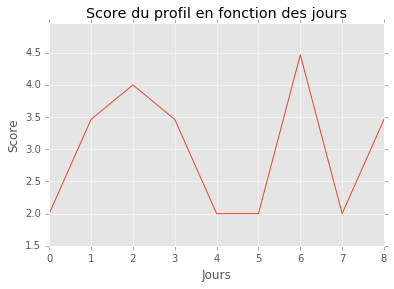

In [23]:
fig, ax = plt.subplots()
ax.plot(l)
ax.set_ylim(min(l)-0.5,max(l)+0.5)
ax.set_title("Score du profil en fonction des jours")
ax.set_xlabel("Jours")
ax.set_ylabel("Score")

Pour en revenir au profil de l'utilisateur il serait représenté par la moyenne ou la somme de l'ensemble des vecteurs extrait des matrices journalières. Pour chaque utilisateur il suffit de garder un vecteur sparse représentant l'écoute des  différentes musiques de la base de Deezer. Pour être mis à jour il suffit de prendren compte la nouvelle matrice créé et de mettre à jour le profil de l'utilisateur. Cela ne requiert pas de garder en mémoire l'ensemble des matrices depuis 17 ans.

On peut alors avoir le profil total de l'utilisateur en sommant les écoutes de chaque jour. cette forme est optimum puisqu'elle permet de garder en mémoire sous une forme optimisé au niveau de la mémoire toutes les informations sur l'utilisateur.

In [24]:
get_profil_from_day_to_day(1, all_tracks_ids, all_artists_ids)

<1x3616 sparse matrix of type '<class 'numpy.float64'>'
	with 40 stored elements in Compressed Sparse Row format>

On pourrait penser améliorer ces métriques en prennant en compte le temps d'écoute des différentes musiques. Cela permettrait d'avoir un certain avis sur le sentiment de l'utilisateur. On pourrait aussi récupérer son comportement sur les différentes plateforme en fonction des différentes musiques. Si elle est écoutée au milieu d'un album ou si elle fait l'objet d'une recherche spécifique ou alors que l'utilisateur revient continuellement sur la même chanson. Cela nous donnerait des informations pertinentes quant au réel intérêt de l'utilisateur sur le tracks plutôt que simplement une écoute. 

Nous pourrions aussi penser à définir une chanson non plus uniquement par son id. Mais aussi par ses caractéristiques intrasèques. Il pourrait être intérressant d'arriver à prendre en compte le style de musique, le rythme, les tendances utilisées dans la musiques. Ces métriques peuvent être surement extraites en effectuant une analyses poussée sur du traitement de signal et donc arriver à déterminer des propriétés à partir directement du son du tracks. En plus de ces métriques plus dures à extraire on pourrait prendre en compte, le courant musical, la date de sortie etc. Cela permettrait de mieux comprendre les habitudes des utilisateurs.

Pour aller plus loin, il pourrait être intérressant de mettre en place des algorithmes d'apprentissage non-supervisés (KMeans par exemple) sur ces matrices de profils pour essayer de détecter des grandes tendances ou des clusters d'utilisateurs écoutant le même type de musique ou ayant les mêmes comportements sur les différentes applications. Il pourrait être alors intéressant d'observer des attentes toutes particulières à l'encontre de ses utilisateurs.

Dans un deuxième temps, les modèles de représentation de données sous leurs formes sparses sont assez compliqué à généraliser pour les modèles. Il faut un grand volume de données pour arriver à obtenir des résultats cohérents (ce qui n'est pas un problème pour Deezer vu le nombre de données journalières récupérées) mais il serait intéressant de mettre en place des algorithmes de réduction de dimensions comme des PCA ou SVD.

### Conclusion

Pour conclure, je propose de stocker le profil utilisateur sous la forme d'un vecteur sparse comprennant les artistes et les tracks écoutés. Ce vecteur est créé chaque jour à partir du fichier représentant les écoutes. On créé alors une matrice TF-IDF permettant de représenté les écoutes. La mise à jour d'un profil est alors très facile il suffit de sommer le profil total avec les nouvelles écoutes générées. Cela peut être fait très facilement et très rapidement à partir d'une infrastructure distribuée de type Apache Spark. 

## Exercice 2

Nous souhaitons proposer aux utilisateurs de pouvoir « follow » sur le site des
utilisateurs ayant des goûts musicaux similaires.
Nous supposons que nous disposons d’une matrice M tel que M(i,j) est une mesure
de similarité entre l’utilisateur i et l’utilisateur j. 


    a. Définir une mesure de similarité. Justifiez. 


Il peut exister plusieurs métriques pour calculer la similarité entre deux utilisateurs. 
- Une pourrait être la distance entre les deux vecteurs de profil de la matrice créée dans l'exercice 1, c'est une simple norme. On évalue la distance entre chaque tracks pour les deux utilisateurs. Plus les deux utilisateurs ont les mêmes habitudes d'écoutes plus la norme sera faible. On pourra alors retrouver les utilisateurs ayant la plus faible distance donc étant les plus similaires. 
- Une deuxième pourrait être la corrélation entre deux variables statistiques  modélisées par les deux vecteurs créés par les écoutes des deux utilisateurs. 
- Une troisième pour être une similarité se basant sur la théorie des recommandations collaboratives. C'est celle que l'on va détailler.

Ici les poids sont représentés par écoutes normalisées des différents utilisateurs plus que par une note attribué ou une valeur binaire. Deezer utilise deux manières de récupérer ces informations, de façon passive et de façon active du point de vu de l'utilisateur. La manière passive est celle expliqué dans l'exercice 1, cela représente les écoutes des différents utilisateurs. La deuxième (active) est celle qui passe par leurs likes et/ou leurs playlists. Le problème ici est que la plupart des données sont manquantes puisques les utilisateurs ne notent ou n'écoutent que très peu de tracks sur la quantité totale proposée par Deezer. Pour palier ce problème on utilise une méthode des plus proche voisin qui utilise une métrique de similarité n'utilisant que les valeurs en communs.  
Il existe alors plusieurs métrique de distance pouvant être utilisées : 
- Jaccard : taille de l'intersection sur la taille de l'union. Cette mesure de similarité n'étant qu'une mesure de cardinalité ne permet pas de prendre en compte la normalisation TF-IDF. https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.jaccard.html
- Cosine : cette mesure prend en compte le produit scalaire et la norme des deux vecteurs. http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

La mesure de similarité utilisant le cosinus est plus pertinente dans cette démarche puisqu'elle permet de prendre en compte la normalisation (term frequency inverse document frequency). En effet, cette mesure est très utilisé dans l'analyse de textes. La mesure de Jaccard peut être utilisé si l'on ne normalise pas et que l'on ne note que pas 0,1 si l'utilisateur à écouté/aimé la chanson ou pas.  

    b. Quelle est la taille maximale de la matrice ? Quelles sont ses propriétés ?  Comment choisiriez-vous de la stocker ? 

La taille maximale de cette matrice est de N² avec N = ~16M, le nombre d'utilisateurs. C'est une matrice symétrique puisque M(i,j) = M(j,i). Cette relation vient de la définition même d'une distance qui doit être symétrique (soit d(x,y) = d(y,x)).  Cette matrice est aussi définie positive. La propriété de parcimonie dépend de la mesure de similarité. Mais je ne peux pas a priori faire d'hypothèse de parcimonie. Pour que la matrice soit pleine il faudrait uniquement que chaque utilisateur ait au moins écouté un tracks en commun avec un autre utilisateur.  
D'après la propriété de symétrie il n'est pas nécessaire de stocker l'intégralité de la matrice. Il suffit de stocker la matrice basse sans la diagonale cela permet de diviser par 2 la taille de la matrice stockée en mémoire. Comme cette matrice est creuse il est intéressant de la stocker de façon creuse pour encore optimiser la mémoire. 






    c. Ecrire dans le langage de votre choix le code correspondant à une fonction getSimilarUsers prenant en paramètre un <user_id> et retournant ses 20 utilisateurs les plus similaires. 

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

On doit dans un premier temps créer la matrice de similarité. On utilisera la matrice du premier jour. 

In [26]:
matrix_day1, cols,users1 = create_df_normalized_on_day(1, all_tracks_ids, all_artists_ids)
similarity_matrix = cosine_similarity(matrix_day1)
similarity_matrix_light = np.tril(similarity_matrix,k=-1)

In [27]:
val_sum =similarity_matrix_light.sum()

On soustrait par la diagonale et divise par deux pour vérifier la cohérence de la démarche.


In [28]:
np.isclose(val_sum, (similarity_matrix.sum()-similarity_matrix.shape[0])/2)

True

In [29]:
user_id_test = 5
sum_i_j = similarity_matrix_light[user_id_test][:] + similarity_matrix_light[:][user_id_test]
assert len(sum_i_j) == len(similarity_matrix_light[1][:])

In [30]:
def get_n_most_similar_using_numpy(user_id, matrix,users, n_bests=20):
    """
    Get N sorted most similar profils for one user_id
    It use mergesort with worst complexity of nlog(n)
    @return 
        - index of similar profils
        - similarity score corresponding
    """
    index_user = users[users.user_id==user_id].index.values[0]
    sum_i_j = matrix[index_user][:] + matrix[:][index_user]
    idx_sorted = sum_i_j.argsort(kind="mergesort")[-n_bests:][::-1]
    return idx_sorted, sum_i_j[idx_sorted]


L'utilisation de l'algorithme mergesort est intéressant pour des grands volumes de données car il est la plupart du temps plus efficace. Mais utilise plus de mémoire. Il faut choisir un algorithme respectant les contraintes de mémoire ou de rapidité. 

In [31]:
def getSimilarUsers(user_id, matrix, users_idx):
    result = get_n_most_similar_using_numpy(user_id, matrix, users_idx)
    df_best = users1.iloc[result[0][result[1]>0]].copy()
    df_best["val"]= result[1][result[1]>0]
    return df_best

In [32]:
all_result = []

for user_id in users1.user_id:
    df = getSimilarUsers(user_id, similarity_matrix_light, users1)
    all_result.append(df.shape[0])

On ne garde que les profils ayant une similarité positive. Les similarités nulles ne sont pas intéressant pour nous. 

In [33]:
getSimilarUsers(users1.user_id[np.array(all_result).argsort()[::-1][0]], similarity_matrix_light, users1)

,user_id,country,val
1298,8523212,UK,1.153781
83,1510784,FR,0.805016
387,3292154,FR,0.668793
1214,8050505,UK,0.610295
505,3986356,UK,0.610295
133,1810344,ES,0.610295
202,2178294,ES,0.581008
1055,7250744,UK,0.563628
221,2301062,UK,0.562240
668,4873313,US,0.556391


In [35]:
!jupyter nbconvert ./TestDeezer.ipynb --to html

[NbConvertApp] Converting notebook ./TestDeezer.ipynb to html
[NbConvertApp] Writing 351855 bytes to .\TestDeezer.html
